In [1]:
## Local LLM experimentation, without langchain

based on https://github.com/mrdbourke/simple-local-rag by www.mrdbourke.com

See Lewis et al. (2020) for first implementation of range
    
https://arxiv.org/abs/2005.11401

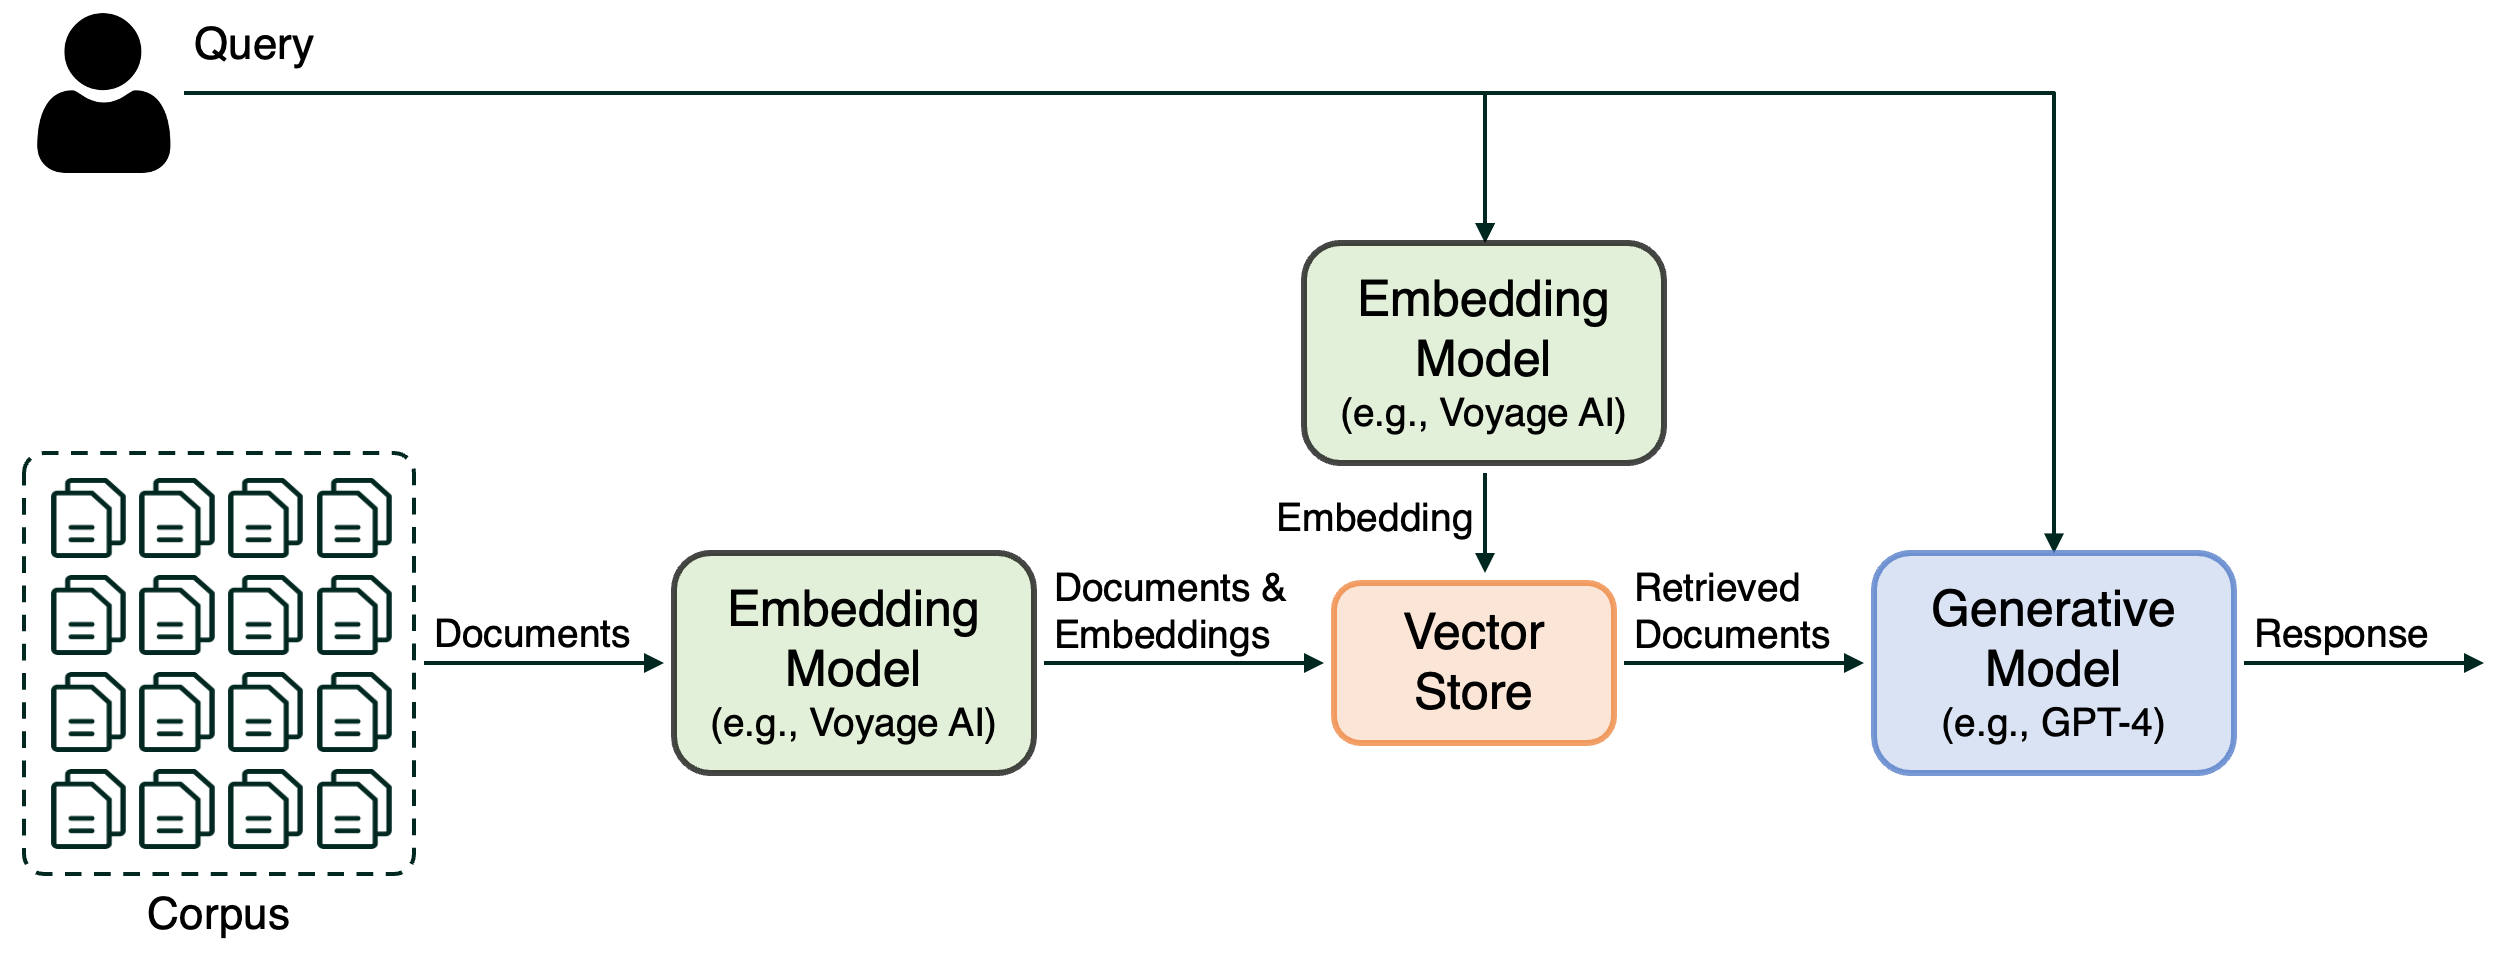

In [1]:
from IPython.display import Image
Image("img/62f4950-rag.png")

Basic RAG workflow

In [ ]:
# If using Google Colab 
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

In [46]:
import os
import re
import requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import fitz 
from tqdm.auto import tqdm 
from glob import glob
import random
import torch
import numpy as np 
import pandas as pd

from spacy.lang.en import English # see https://spacy.io/usage for install instructions
# Requires !pip install sentence-transformers
from sentence_transformers import util, SentenceTransformer

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available 
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
from transformers import BitsAndBytesConfig

In [3]:
#get pdfs if havent downloaded already
def get_pdfs():
    url = "https://aws.amazon.com/whitepapers/?whitepapers-main.sort-by=item.additionalFields.sortDate&whitepapers-main.sort-order=desc&awsf.whitepapers-content-type=content-type%23whitepaper%7Ccontent-type%23tech-guide&awsf.whitepapers-global-methodology=*all&awsf.whitepapers-tech-category=tech-category%23ai-ml%7Ctech-category%23analytics&awsf.whitepapers-industries=*all&awsf.whitepapers-business-category=*all"

    #If there is no such folder, the script will create one automatically
    folder_location = r'aws_whitepapers'
    if not os.path.exists(folder_location):os.mkdir(folder_location)

    response = requests.get(url)
    soup= BeautifulSoup(response.text, "html.parser")     
    for link in soup.select("a[href$='.pdf']"):
        #Name the pdf files using the last portion of each link which are unique in this case
        filename = os.path.join(folder_location,link['href'].split('/')[-1])
        with open(filename, 'wb') as f:
            f.write(requests.get(urljoin(url,link['href'])).content)

In [4]:
pdf_path = "/mnt/1TB_2/Data/ML_Data/aws_whitepapers"

if not os.path.exists(pdf_path):
  print("Dir doesn't exist, downloading...")
  get_pdfs()
else:
  print(f"File {pdf_path} exists.")

File /mnt/1TB_2/Data/ML_Data/aws_whitepapers exists.


In [5]:
def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text

In [6]:
# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a folder containing PDF files, reads their text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path.

    Returns:
        list[dict]: A list of dictionaries, each containing the file name, page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """

    pdfs = glob(f"{pdf_path}/*.pdf")
    pdf_data= {}
    for f in pdfs:
        doc = fitz.open(f) 
        pages_and_texts = []
        for page_number, page in tqdm(enumerate(doc)):  
            text = page.get_text()  # get plain text encoded as UTF-8
            text = text_formatter(text)
            pages_and_texts.append({"page_number": page_number, 
                                    "page_char_count": len(text),
                                    "page_word_count": len(text.split(" ")),
                                    "page_sentence_count_raw": len(text.split(". ")),
                                    "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                    "text": text})
        file_name=f.rsplit('/', 1)[-1]
        pdf_data[file_name]=pages_and_texts
    return pdf_data


In [7]:
pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [8]:
pages_and_texts.keys()

dict_keys(['hybrid-machine-learning.pdf', 'planning-ai-business-journey-with-accenture-on-aws.pdf', 'aws-overview.pdf', 'aws-glue-best-practices-build-efficient-data-pipeline.pdf', 'augmented-ai-the-power-of-human-and-machine.pdf', 'accenture-ai-scaling-ml-and-deep-learning-models.pdf', 'wellarchitected-machine-learning-lens.pdf', 'wellarchitected-sustainability-pillar.pdf', 'ml-best-practices-healthcare-life-sciences.pdf', 'aws-glue-best-practices-build-performant-data-pipeline.pdf', 'cost-modeling-data-lakes.pdf', 'wellarchitected-framework.pdf', 'build-modern-data-streaming-analytics-architectures.pdf', 'aws-caf-for-ai.pdf', 'model-explainability-aws-ai-ml.pdf', 'aws-cloud-data-ingestion-patterns-practices.pdf', 'big-data-analytics-options.pdf', 'wellarchitected-performance-efficiency-pillar.pdf', 'time-series-forecasting-principles-with-amazon-forecast.pdf', 'derive-insights-from-aws-modern-data.pdf', 'sagemaker-studio-admin-best-practices.pdf', 'wellarchitected-operational-excelle

In [9]:
res = key, val = random.choice(list(pages_and_texts.items()))

In [10]:
res

('derive-insights-from-aws-modern-data.pdf',
 [{'page_number': 0,
   'page_char_count': 136,
   'page_word_count': 21,
   'page_sentence_count_raw': 3,
   'page_token_count': 34.0,
   'text': 'AWS Whitepaper Derive Insights from AWS Modern Data Copyright © 2024 Amazon Web Services, Inc. and/or its aﬃliates. All rights reserved.'},
  {'page_number': 1,
   'page_char_count': 590,
   'page_word_count': 101,
   'page_sentence_count_raw': 5,
   'page_token_count': 147.5,
   'text': "Derive Insights from AWS Modern Data AWS Whitepaper Derive Insights from AWS Modern Data: AWS Whitepaper Copyright © 2024 Amazon Web Services, Inc. and/or its aﬃliates. All rights reserved. Amazon's trademarks and trade dress may not be used in connection with any product or service  that is not Amazon's, in any manner that is likely to cause confusion among customers, or in any  manner that disparages or discredits Amazon. All other trademarks not owned by Amazon are  the property of their respective owners, wh

### split pages into sentences

In [11]:
nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [12]:
for k,l in pages_and_texts.items():
    print(k) 
    for v in l:
        v["sentences"] = list(nlp(v["text"]).sents)
        
        # Make sure all sentences are strings
        v["sentences"] = [str(sentence) for sentence in v["sentences"]]
        
        # Count the sentences 
        v["page_sentence_count_spacy"] = len(v["sentences"])

hybrid-machine-learning.pdf
planning-ai-business-journey-with-accenture-on-aws.pdf
aws-overview.pdf
aws-glue-best-practices-build-efficient-data-pipeline.pdf
augmented-ai-the-power-of-human-and-machine.pdf
accenture-ai-scaling-ml-and-deep-learning-models.pdf
wellarchitected-machine-learning-lens.pdf
wellarchitected-sustainability-pillar.pdf
ml-best-practices-healthcare-life-sciences.pdf
aws-glue-best-practices-build-performant-data-pipeline.pdf
cost-modeling-data-lakes.pdf
wellarchitected-framework.pdf
build-modern-data-streaming-analytics-architectures.pdf
aws-caf-for-ai.pdf
model-explainability-aws-ai-ml.pdf
aws-cloud-data-ingestion-patterns-practices.pdf
big-data-analytics-options.pdf
wellarchitected-performance-efficiency-pillar.pdf
time-series-forecasting-principles-with-amazon-forecast.pdf
derive-insights-from-aws-modern-data.pdf
sagemaker-studio-admin-best-practices.pdf
wellarchitected-operational-excellence-pillar.pdf
build-e2e-data-driven-applications.pdf
best-practices-buildi

In [13]:
frames=[]
for k, v in pages_and_texts.items():
    df = pd.DataFrame(v)
    df['title']=k.split('.pdf')[0]
    frames.append(df)
df_data = pd.concat(frames, ignore_index=True, axis=0)
# Get stats
df_data.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,3482.00,3482.00,3482.00,3482.00,3482.00,3482.00
mean,157.84,1814.71,276.09,12.69,453.68,12.27
std,214.32,794.23,114.36,7.00,198.56,6.47
min,0.00,88.00,12.00,1.00,22.00,1.00
25%,23.00,1355.00,204.00,8.00,338.75,7.00
50%,66.00,1833.00,279.00,12.00,458.25,13.00
75%,174.00,2304.75,360.75,17.00,576.19,17.00
max,880.00,5569.00,790.00,40.00,1392.25,33.00


### Chunking 

In [14]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 12 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for k,l in pages_and_texts.items():
    for v in l:
        v["sentence_chunks"] = split_list(input_list=v["sentences"],
                                         slice_size=num_sentence_chunk_size)
        v["num_chunks"] = len(v["sentence_chunks"])

In [15]:
frames=[]
for k, v in pages_and_texts.items():
    df = pd.DataFrame(v)
    df['title']=k.split('.pdf')[0]
    frames.append(df)
df_data = pd.concat(frames, ignore_index=True, axis=0)
# Get stats
df_data.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,3482.00,3482.00,3482.00,3482.00,3482.00,3482.00,3482.00
mean,157.84,1814.71,276.09,12.69,453.68,12.27,1.53
std,214.32,794.23,114.36,7.00,198.56,6.47,0.55
min,0.00,88.00,12.00,1.00,22.00,1.00,1.00
25%,23.00,1355.00,204.00,8.00,338.75,7.00,1.00
50%,66.00,1833.00,279.00,12.00,458.25,13.00,2.00
75%,174.00,2304.75,360.75,17.00,576.19,17.00,2.00
max,880.00,5569.00,790.00,40.00,1392.25,33.00,3.00


In [16]:

# Split each chunk into its own item
pages_and_chunks = []
for k,l in pages_and_texts.items():
    for item in l:
        for sentence_chunk in item["sentence_chunks"]:
            chunk_dict = {}
            chunk_dict["page_number"] = item["page_number"]
            
            # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
            joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
            joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
            chunk_dict["sentence_chunk"] = joined_sentence_chunk

            # Get stats about the chunk
            chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
            chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
            chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
            
            pages_and_chunks.append(chunk_dict)                                                 

# How many chunks do we have?
len(pages_and_chunks)

5312

In [17]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 77,
  'sentence_chunk': 'Use On-Demand Instances to supplement your developer devices. •Use instance types with burst capacity, Spot Instances, and other technologies to align build capacity with use. •Adopt native cloud services for secure instance shell access rather than deploying ﬂeets of bastion hosts. •Automatically scale your build resources depending on your build jobs. Resources Related documents: • AWS Systems Manager Session Manager SUS06-BP03 Increase utilization of build environments 74',
  'chunk_char_count': 479,
  'chunk_word_count': 67,
  'chunk_token_count': 119.75}]

In [18]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,5312.00,5312.00,5312.00,5312.00
mean,161.69,1178.83,170.62,294.71
std,213.80,714.05,90.53,178.51
min,0.00,1.00,1.00,0.25
25%,25.00,638.00,96.00,159.50
50%,71.50,1219.50,182.00,304.88
75%,177.25,1630.00,242.00,407.50
max,880.00,5569.00,418.00,1392.25


In [19]:
# Show random chunks with under 10 tokens in length
min_token_length = 10
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 8.25 | Text: Robotics Quantum technologies 113
Chunk token count: 8.25 | Text: Lifecycle architecture diagram 45
Chunk token count: 4.25 | Text: Partition data 19
Chunk token count: 0.5 | Text: 90
Chunk token count: 4.5 | Text: AWS Local Zones 27


In [20]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 0,
  'sentence_chunk': 'AWS Whitepaper Hybrid Machine Learning Copyright © 2024 Amazon Web Services, Inc. and/or its aﬃliates. All rights reserved.',
  'chunk_char_count': 123,
  'chunk_word_count': 18,
  'chunk_token_count': 30.75},
 {'page_number': 1,
  'sentence_chunk': "Hybrid Machine Learning AWS Whitepaper Hybrid Machine Learning: AWS Whitepaper Copyright © 2024 Amazon Web Services, Inc. and/or its aﬃliates. All rights reserved. Amazon's trademarks and trade dress may not be used in connection with any product or service that is not Amazon's, in any manner that is likely to cause confusion among customers, or in any manner that disparages or discredits Amazon. All other trademarks not owned by Amazon are the property of their respective owners, who may or may not be aﬃliated with, connected to, or sponsored by Amazon.",
  'chunk_char_count': 560,
  'chunk_word_count': 91,
  'chunk_token_count': 140.0}]

## Models to try:

https://www.sbert.net/docs/pretrained_models.html

multi-qa-MiniLM-L6-cos-v1

msmarco-distilbert-base-tas-b

hkunlp/instructor-base

nq-distilbert-base-v1

facebook-dpr-ctx_encoder-single-nq-base

see SentenceTransformer class for old models

https://huggingface.co/spaces/mteb/leaderboard

https://docs.voyageai.com/docs/quickstart-tutorial

In [21]:

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cuda") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

In [22]:
# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981504e-02  3.03164795e-02 -2.01218072e-02  6.86483607e-02
 -2.55255029e-02 -8.47689435e-03 -2.07098899e-04 -6.32377192e-02
  2.81605944e-02 -3.33352871e-02  3.02634798e-02  5.30720539e-02
 -5.03526144e-02  2.62288153e-02  3.33314165e-02 -4.51578610e-02
  3.63044254e-02 -1.37111626e-03 -1.20171392e-02  1.14946552e-02
  5.04510589e-02  4.70856987e-02  2.11913120e-02  5.14607430e-02
 -2.03746744e-02 -3.58889401e-02 -6.67856424e-04 -2.94393003e-02
  4.95859012e-02 -1.05639780e-02 -1.52014084e-02 -1.31754915e-03
  4.48197201e-02  1.56022916e-02  8.60380283e-07 -1.21391157e-03
 -2.37978697e-02 -9.09399474e-04  7.34481914e-03 -2.53934227e-03
  5.23370057e-02 -4.68043461e-02  1.66214723e-02  4.71579060e-02
 -4.15599607e-02  9.01906868e-04  3.60278785e-02  3.42214480e-02
  9.68227237e-02  5.94828427e-02 -1.64984819e-02 -3.51249650e-02
  5.92515431e-03 -7.08000560e-04 -2.4103

In [23]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447278e-02 -4.51085251e-03 -4.98482818e-03  6.55444935e-02
 -9.87670664e-03  2.72835586e-02  3.66425999e-02 -3.30220186e-03
  8.50078557e-03  8.24951101e-03 -2.28497330e-02  4.02430333e-02
 -5.75200208e-02  6.33692592e-02  4.43207808e-02 -4.49507348e-02
  1.25284456e-02 -2.52012182e-02 -3.55292223e-02  1.29559133e-02
  8.67023785e-03 -1.92917567e-02  3.55633581e-03  1.89506095e-02
 -1.47128245e-02 -9.39847529e-03  7.64171500e-03  9.62191354e-03
 -5.98926842e-03 -3.90169583e-02 -5.47824502e-02 -5.67457080e-03
  1.11645162e-02  4.08067331e-02  1.76319122e-06  9.15297307e-03
 -8.77260137e-03  2.39382721e-02 -2.32784506e-02  8.04999769e-02
  3.19176838e-02  5.12596080e-03 -1.47708301e-02 -1.62524506e-02
 -6.03213459e-02 -4.35689688e-02  4.51211371e-02 -1.79053675e-02
  2.63366960e-02 -3.47867087e-02 -8.89172591e-03 -5.47675081e-02
 -1.24373073e-02 -2.38606762e-02  8.33496898e-02  5.71242347e-02
  1.13328779e-02 -1.49595076e-02  9.2037

In [24]:
# %%time

# # Uncomment to see how long it takes to create embeddings on CPU
# # # Make sure the model is on the CPU
# embedding_model.to("cpu")

# # # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

In [25]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed
# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/5231 [00:00<?, ?it/s]

CPU times: user 5min 51s, sys: 1.2 s, total: 5min 52s
Wall time: 1min 22s


In [26]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [27]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 1min, sys: 1.04 s, total: 1min 1s
Wall time: 32.9 s


tensor([[-0.0374,  0.0348, -0.0323,  ..., -0.0014, -0.0210,  0.0086],
        [-0.0168, -0.0024, -0.0535,  ..., -0.0475, -0.0188, -0.0034],
        [-0.0276, -0.0068, -0.0438,  ...,  0.0081, -0.0465, -0.0130],
        ...,
        [ 0.0344, -0.0719, -0.0087,  ...,  0.0086,  0.0281, -0.0098],
        [ 0.0343, -0.0492, -0.0253,  ...,  0.0256, -0.0298, -0.0212],
        [ 0.0312, -0.0241, -0.0250,  ...,  0.0033, -0.0065, -0.0099]],
       device='cuda:0')

In [28]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "all-mpnet-base-v2_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [29]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,AWS Whitepaper Hybrid Machine Learning Copyrig...,123,18,30.75,[-3.73911187e-02 3.48335765e-02 -3.23467776e-...
1,1,Hybrid Machine Learning AWS Whitepaper Hybrid ...,560,91,140.00,[-1.68129671e-02 -2.42296094e-03 -5.35295084e-...
2,2,Hybrid Machine Learning AWS Whitepaper Table o...,4678,281,1169.50,[-2.75664367e-02 -6.76154811e-03 -4.37569767e-...
3,3,Hybrid Machine Learning AWS Whitepaper Hybrid ...,1828,55,457.00,[-3.10437530e-02 -2.66948417e-02 -5.13217114e-...
4,4,Hybrid Machine Learning AWS Whitepaper Hybrid ...,1796,289,449.00,[ 1.40210409e-02 4.14555706e-02 -2.85774618e-...


In [30]:


device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("all-mpnet-base-v2_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([5231, 768])

In [31]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,AWS Whitepaper Hybrid Machine Learning Copyrig...,123,18,30.75,"[-0.0373911187, 0.0348335765, -0.0323467776, -..."
1,1,Hybrid Machine Learning AWS Whitepaper Hybrid ...,560,91,140.00,"[-0.0168129671, -0.00242296094, -0.0535295084,..."
2,2,Hybrid Machine Learning AWS Whitepaper Table o...,4678,281,1169.50,"[-0.0275664367, -0.00676154811, -0.0437569767,..."
3,3,Hybrid Machine Learning AWS Whitepaper Hybrid ...,1828,55,457.00,"[-0.031043753, -0.0266948417, -0.0513217114, -..."
4,4,Hybrid Machine Learning AWS Whitepaper Hybrid ...,1796,289,449.00,"[0.0140210409, 0.0414555706, -0.0285774618, -0..."


In [32]:
embeddings[0]

tensor([-3.7391e-02,  3.4834e-02, -3.2347e-02, -2.9220e-03, -2.6389e-02,
         1.4836e-03,  3.8320e-02, -1.2748e-02,  3.7425e-02, -4.0589e-02,
         4.9718e-02, -6.7971e-03, -1.2541e-02,  8.3530e-02, -3.3210e-03,
        -7.8564e-02,  3.4512e-02,  4.5739e-02,  6.5478e-03, -1.5649e-02,
        -2.1956e-02,  9.5496e-03,  1.9075e-03,  1.4053e-02, -3.0766e-02,
         1.0283e-02, -1.2569e-02, -1.8800e-02,  1.2500e-02,  3.4050e-02,
         4.0614e-02, -3.9782e-02,  8.1236e-03,  7.4680e-02,  1.5302e-06,
        -4.8615e-02, -1.0766e-02,  1.4544e-02, -5.9916e-03, -5.1934e-02,
         4.0766e-02,  3.6328e-03,  2.3235e-02,  3.9827e-02, -4.3907e-02,
         7.5179e-03,  3.5532e-02,  2.3075e-02,  6.5210e-02,  5.1383e-02,
        -2.7601e-02,  2.6893e-02,  5.5502e-02,  1.8494e-02,  9.5751e-03,
         2.0864e-02, -1.3246e-02, -3.1415e-02, -1.1509e-02, -6.0817e-02,
         3.2700e-02,  1.5757e-02,  3.4394e-02,  5.6735e-02,  2.6579e-02,
         3.6983e-02, -4.8301e-02,  3.3064e-03, -6.2

In [33]:


embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

In [34]:
# 1. Define the query
query = "What are the 4 stages of the AWS cloud adoption framework?"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: What are the 4 stages of the AWS cloud adoption framework?
Time take to get scores on 5231 embeddings: 0.00730 seconds.


torch.return_types.topk(
values=tensor([0.7885, 0.7816, 0.7813, 0.7405, 0.7380], device='cuda:0'),
indices=tensor([5176, 5177, 5227, 5174, 5229], device='cuda:0'))

In [35]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([523100, 768])
Time take to get scores on 523100 embeddings: 0.00040 seconds.


In [36]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [37]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'What are the 4 stages of the AWS cloud adoption framework?'

Results:
Score: 0.7885
Text:
An Overview of the AWS Cloud Adoption Framework AWS Whitepaper Your cloud
transformation journey Each organization’s cloud journey is unique. To succeed
in your transformation, you’ll need to envision your desired target state,
understand your cloud readiness, and adopt an agile approach to closing the
gaps. Transforming incrementally will allow you to demonstrate value quickly
while minimizing the need to make far-reaching predictions. Adopting an
iterative approach will help you maintain momentum and evolve your roadmap as
you learn from experience. The AWS CAF recommends four iterative and incremental
cloud transformation phases shown in the following ﬁgure. Cloud transformation
journey • Envision phase focuses on demonstrating how cloud will help accelerate
your business outcomes. It does so by identifying and prioritizing
transformation opportunities across each of the four transforma

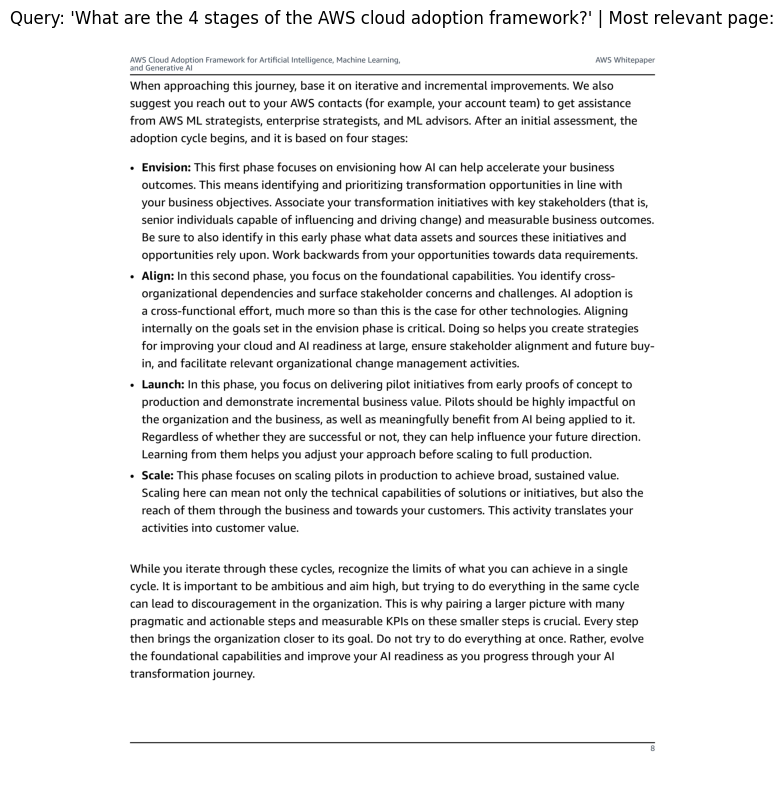

In [38]:
pdf_file = "/mnt/1TB_2/Data/ML_Data/aws_whitepapers/aws-caf-for-ai.pdf"
doc = fitz.open(pdf_file)
page = doc.load_page(11) 

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

### Similarity measures: dot product and cosine similarity 

Let's talk similarity measures between vectors.

Specifically, embedding vectors which are representations of data with magnitude and direction in high dimensional space (our embedding vectors have 768 dimensions).

Two of the most common you'll across are the dot product and cosine similarity.

They are quite similar.

The main difference is that cosine similarity has a normalization step.

| Similarity measure | Description | Code |
| ----- | ----- | ----- |
| [Dot Product](https://en.wikipedia.org/wiki/Dot_product) | - Measure of magnitude and direction between two vectors<br>- Vectors that are aligned in direction and magnitude have a higher positive value<br>- Vectors that are opposite in direction and magnitude have a higher negative value | [`torch.dot`](https://pytorch.org/docs/stable/generated/torch.dot.html), [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [`sentence_transformers.util.dot_score`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.dot_score) | 
| [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) | - Vectors get normalized by magnitude/[Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics))/L2 norm so they have unit length and are compared more so on direction<br>- Vectors that are aligned in direction have a value close to 1<br>- Vectors that are opposite in direction have a value close to -1 | [`torch.nn.functional.cosine_similarity`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html), [`1 - scipy.spatial.distance.cosine`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) (subtract the distance from 1 for similarity measure), [`sentence_transformers.util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.cos_sim) |

For text similarity, you generally want to use cosine similarity as you are after the semantic measurements (direction) rather than magnitude. 

In our case, our embedding model `all-mpnet-base-v2` outputs normalized outputs (see the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers) for more on this) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.

To make things bit more concrete, let's make simple dot product and cosine similarity functions and view their results on different vectors.

> **Note:** Similarity measures between vectors and embeddings can be used on any kind of embeddings, not just text embeddings. For example, you could measure image embedding similarity or audio embedding similarity. Or with text and image models like [CLIP](https://github.com/mlfoundations/open_clip), you can measure the similarity between text and image embeddings.

In [39]:

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


Notice for both dot product and cosine similarity the comparisons of `vector1` and `vector2` are the opposite of `vector1` and `vector4`.

Comparing `vector1` and `vector2` both equations return positive values (14 for dot product and 1.0 for cosine similarity). 

But comparing `vector1` and `vector4` the result is in the negative direction.

This makes sense because `vector4` is the negative version of `vector1`.

Whereas comparing `vector1` and `vector3` shows a different outcome.

For the dot product, the value is positive and larger then the comparison of two exactly the same vectors (32 vs 14).

However, for the cosine similarity, thanks to the normalization step, comparing `vector1` and `vector3` results in a postive value close to 1 but not exactly 1.

It is because of this that when comparing text embeddings, cosine similarity is generally favoured as it measures the difference in direction of a pair of vectors rather than difference in magnitude.

And it is this difference in direction that is more generally considered to capture the semantic meaning/vibe of the text.

The good news is that as mentioned before, the outputs of our embedding model `all-mpnet-base-v2` are already normalized.

So we can continue using the dot product (cosine similarity is dot product + normalization).

With similarity measures explained, let's functionize our semantic search steps from above so we can repeat them. 

### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [40]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [41]:
query = "What is the purpose of model explainability?"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 5231 embeddings: 0.00012 seconds.


(tensor([0.7300, 0.7018, 0.7014, 0.6792, 0.6788], device='cuda:0'),
 tensor([2616, 2598, 2597, 2599, 2628], device='cuda:0'))

In [42]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 5231 embeddings: 0.00014 seconds.
Query: What is the purpose of model explainability?

Results:
Score: 0.7300
To help associate domains of explainability with real-world AI/ML scenarios,
each industry use case is tagged with one or more of the model explainability
pillars. Common industries 16
Page number: 18


Score: 0.7018
For example, a news media outlet uses a neural network to assign categories to
diﬀerent articles. The news outlet cannot interpret the model in depth; however,
they can use a model agnostic approach to evaluate the input article data versus
the model predictions. With this approach, they ﬁnd that the model is assigning
the Sports category to business articles that mention sport organizations.
Although the news outlet did not use model interpretability, they were still
able to derive an explainable answer to reveal the model’s behavior. When
starting a new AI/ML project, you need to consider whether interpretability is
required. Mo

### Semantic search/vector search extensions 

We've covered an exmaple of using embedding vector search to find relevant results based on a query.

However, you could also add to this pipeline with traditional keyword search.

Many modern search systems use keyword and vector search in tandem.

Our dataset is small and allows for an exhaustive search (comparing the query to *every* possible result) but if you start to work with large scale datasets with hundred of thousands, millions or even billions of vectors, you'll want to implement an index.

You can think of an index as sorting your embeddings before you search through them.

So it narrows down the search space.

For example, it would be inefficient to search every word in the dictionary to find the word "duck", instead you'd go straight to the letter D, perhaps even straight to the back half of the letter D, find words close to "duck" before finding it.

That's how an index can help search through many examples without comprimising too much on speed or quality (for more on this, check out [nearest neighbour search](https://en.wikipedia.org/wiki/Nearest_neighbor_search)).

One of the most popular indexing libraries is [Faiss](https://github.com/facebookresearch/faiss). 

Faiss is open-source and was originally created by Facebook to deal with internet-scale vectors and implements many algorithms such as [HNSW](https://arxiv.org/abs/1603.09320) (Hierarchical Naviganle Small Worlds).

### Getting an LLM for local generation

We're got our retrieval pipeline ready, let's now get the generation side of things happening.

To perform generation, we're going to use a Large Language Model (LLM).

LLMs are designed to generate an output given an input.

In our case, we want our LLM to generate and output of text given a input of text.

And more specifically, we want the output of text to be generated based on the context of relevant information to the query.

The input to an LLM is often referred to as a prompt.

We'll augment our prompt with a query as well as context from our textbook related to that query.

> **Which LLM should I use?**

There are many LLMs available.

Two of the main questions to ask from this is:
1. Do I want it to run locally? 
2. If yes, how much compute power can I dedicate?

If you're after the absolute best performance, you'll likely want to use an API (not running locally) such as GPT-4 or Claude 3. However, this comes with the tradeoff of sending your data away and then awaiting a response.

For our case, since we want to set up a local pipeline and run it on our own GPU, we'd answer "yes" to the first question and then the second question will depend on what hardware we have available.

To find open-source LLMs, one great resource is the [Hugging Face open LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

The leaderboard compares many of the latest and greatest LLMs on various benchmarks.

Another great resource is [TheBloke on Hugging Face](https://huggingface.co/TheBloke), an account which provides an extensive range of quantized (models that have been made smaller) LLMs.

A rule of thumb for LLMs (and deep learning models in general) is that the higher the number of parameters, the better the model performs. 

It may be tempting to go for the largest size model (e.g. a 70B parameter model rather than a 7B parameter model) but a larger size model may not be able to run on your available hardware.

The following table gives an insight into how much GPU memory you'll need to load an LLM with different sizes and different levels of [numerical precision](https://en.wikipedia.org/wiki/Precision_(computer_science)).

They are based on the fact that 1 float32 value (e.g. `0.69420`) requires 4 bytes of memory and 1GB is approximately 1,000,000,000 (one billion) bytes.

| Model Size (Billion Parameters) | Float32 VRAM (GB) | Float16 VRAM (GB) | 8-bit VRAM (GB) | 4-bit VRAM (GB) |
|-----|-----|-----|-----|-----|
| 1B                              | ~4                | ~2                | ~1              | ~0.5            |
| 7B (e.g., [Llama 2 7B](https://huggingface.co/meta-llama/Llama-2-7b), [Gemma 7B](https://huggingface.co/google/gemma-7b-it), [Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-v0.1))             | ~28               | ~14               | ~7              | ~3.5            |
| 10B                             | ~40               | ~20               | ~10             | ~5              |
| 70B (e.g, Llama 2 70B)          | ~280              | ~140              | ~70             | ~35             |
| 100B                            | ~400              | ~200              | ~100            | ~50             |
| 175B                            | ~700              | ~350              | ~175            | ~87.5           |

<br>

> **Note:** Loading a model in a lower precision (e.g. 8-bit instead of float16) generally lowers performance. Lower precision can help to reduce computing requirements, however sometimes the performance degradation in terms of model output can be substantial. Finding the right speed/performance tradeoff will often require many experiments.

### Checking local GPU memory availability

Let's find out what hardware we've got available and see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [43]:
# Get GPU available memory

gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 11 GB



Let's try out the recently released (at the time of writing, March 2024) LLM from Google, [Gemma](https://huggingface.co/blog/gemma).

Specifically, we'll use the `gemma-7b-it` version which stands for Gemma 7B Instruction-Tuned.

Instruction tuning is the process of tuning a raw language model to follow instructions.

These are the kind of models you'll find in most chat-based assistants such as ChatGPT, Gemini or Claude.

The following table shows different amounts of GPU memory requirements for different verions of the Gemma LLMs with varying levels of precision.

| Model             | Precision | Min-Memory (Bytes) | Min-Memory (MB) | Min-Memory (GB) | Recommended Memory (GB) | Hugging Face ID |
|-------------------|-----------|----------------|-------------|-------------| ----- | ----- |
| [Gemma 2B](https://huggingface.co/google/gemma-2b-it)          | 4-bit     | 2,106,749,952  | 2009.15     | 1.96        | ~5.0 | [`gemma-2b`](https://huggingface.co/google/gemma-2b) or [`gemma-2b-it`](https://huggingface.co/google/gemma-2b-it) for instruction tuned version | 
| Gemma 2B          | Float16   | 5,079,453,696  | 4844.14     | 4.73        | ~8.0 | Same as above |
| [Gemma 7B](https://huggingface.co/google/gemma-7b-it)          | 4-bit     | 5,515,859,968  | 5260.33     | 5.14        | ~8.0 | [`gemma-7b`](https://huggingface.co/google/gemma-7b) or [`gemma-7b-it`](https://huggingface.co/google/gemma-7b-it) for instruction tuned version |
| Gemma 7B          | Float16   | 17,142,470,656 | 16348.33    | 15.97       | ~19 | Same as above |

> **Note:** `gemma-7b-it` means "instruction tuned", as in, a base LLM (`gemma-7b`) has been fine-tuned to follow instructions, similar to [`Mistral-7B-v0.1`](https://huggingface.co/mistralai/Mistral-7B-v0.1) and [`Mistral-7B-Instruct-v0.1`](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1).
> 
> There are also further quantized and smaller variants of Gemma (and other LLMs) available in various formats such as GGUF. You can see many of these on [TheBloke account on Hugging Face](https://huggingface.co/TheBloke).
> 
> The version of LLM you choose to use will be largely based on project requirements and experimentation.

Based on the table above, let's write a simple if/else statement which recommends which Gemma variant we should look into using.

In [44]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 11 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


### Loading an LLM locally

change the `model_id` and `use_quantization_config` values as per VRAM 

There are plenty of examples of how to load the model on the `gemma-7b-it` [Hugging Face model card](https://huggingface.co/google/gemma-7b-it).

Good news is, the Hugging Face [`transformers`](https://huggingface.co/docs/transformers/) library has all the tools we need.

To load our LLM, we're going to need a few things:
1. A quantization config (optional) - This will determine whether or not we load the model in 4bit precision for lower memory usage. The we can create this with the [`transformers.BitsAndBytesConfig`](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/quantization#transformers.BitsAndBytesConfig) class (requires installing the [`bitsandbytes` library](https://github.com/TimDettmers/bitsandbytes)).
2. A model ID - This is the reference Hugging Face model ID which will determine which tokenizer and model gets used. For example `gemma-7b-it`.
3. A tokenzier - This is what will turn our raw text into tokens ready for the model. We can create it using the [`transformers.AutoTokenzier.from_pretrained`](https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/auto#transformers.AutoTokenizer) method and passing it our model ID.
4. An LLM model - Again, using our model ID we can load a specific LLM model. To do so we can use the [`transformers.AutoModelForCausalLM.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM.from_pretrained) method and passing it our model ID as well as other various parameters.

As a bonus, we'll check if [Flash Attention 2](https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2) is available using `transformers.utils.is_flash_attn_2_available()`. Flash Attention 2 speeds up the attention mechanism in Transformer architecture models (which is what many modern LLMs are based on, including Gemma). So if it's available and the model is supported (not all models support Flash Attention 2), we'll use it. If it's not available, you can install it by following the instructions on the [GitHub repo](https://github.com/Dao-AILab/flash-attention). 

> **Note:** Flash Attention 2 currently works on NVIDIA GPUs with a compute capability score of 8.0+ (Ampere, Ada Lovelace, Hopper architectures). We can check our GPU compute capability score with [`torch.cuda.get_device_capability(0)`](https://pytorch.org/docs/stable/generated/torch.cuda.get_device_capability.html). 

> **Note:** To get access to the Gemma models, you will have to [agree to the terms & conditions](https://huggingface.co/google/gemma-7b-it) on the Gemma model page on Hugging Face. You will then have to authorize your local machine via the [Hugging Face CLI/Hugging Face Hub `login()` function](https://huggingface.co/docs/huggingface_hub/en/quick-start#authentication). Once you've done this, you'll be able to download the models. If you're using Google Colab, you can add a [Hugging Face token](https://huggingface.co/docs/hub/en/security-tokens) to the "Secrets" tab.
>
> Downloading an LLM locally can take a fair bit of time depending on your internet connection. Gemma 7B is about a 16GB download and Gemma 2B is about a 6GB download.



In [48]:


# 1. Create quantization config for smaller model loading (optional)
# For models that require 4-bit quantization (use this if you have low GPU memory available)

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention 
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model) 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory 
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [49]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

Ok, ok a bunch of layers ranging from embedding layers to attention layers (see the `GemmaFlashAttention2` layers!) to MLP and normalization layers.

The good news is that we don't have to know too much about these to use the model.

How about we get the number of parameters in our model? 

In [50]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [51]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012344832, 'model_mem_mb': 4780.14, 'model_mem_gb': 4.67}

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

It's important to note that you should use a tokenizer that has been paired with a model.

Otherwise if you try to use a different tokenizer and then pass those inputs to a model, you will likely get errors/strange results.

For some LLMs, there's a specific template you should pass to them for ideal outputs.

For example, the `gemma-7b-it` model has been trained in a dialogue fashion (instruction tuning).

In this case, our `tokenizer` has a [`apply_chat_template()` method](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) which can prepare our input text in the right format for the model.

Let's try it out.

> **Note:** The following demo has been modified from the Hugging Face model card for [Gemma 7B](https://huggingface.co/google/gemma-7b-it). Many similar demos of usage are available on the model cards of similar models.

In [52]:
input_text = "How should I best set up SageMaker Studio domain authentication for user identities?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
How should I best set up SageMaker Studio domain authentication for user identities?

Prompt (formatted):
<bos><start_of_turn>user
How should I best set up SageMaker Studio domain authentication for user identities?<end_of_turn>
<start_of_turn>model



In [53]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   2299,   1412,    590,   1963,
           1142,    908,  44985,  45145,  17095,  11988,  34671,    604,   2425,
          58382, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   2299,   1412,    590,   1963,
          1142,    908,  44985,  45145,  17095,  11988,  34671,    604,   2425,
         58382, 235336,    107,    108,    106,   2516,    108,    688,   5856,
        235248, 235274, 235292,   7319,    476,  44985,  45145,  17095,  11988,
           688,    109, 235287,   7555,    575,    577,    573,  42556,   7219,
         33858, 235265,    108, 235287, 103601,    577,    573,  44985,  45145,
         17095,  10647, 235265,    108, 235287,   9711,    611,    664, 

In [54]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
How should I best set up SageMaker Studio domain authentication for user identities?<end_of_turn>
<start_of_turn>model
**Step 1: Create a SageMaker Studio domain**

* Sign in to the AWS Management Console.
* Navigate to the SageMaker Studio console.
* Click on "Domain" in the left-hand navigation panel.
* Follow the steps to create a new domain and configure its settings.

**Step 2: Configure domain authentication**

* Once your domain is created, you can configure domain authentication.
* Navigate to the "Domain" section in the SageMaker Studio console.
* Select the domain you want to configure.
* Click on "Authentication Method" and select "Custom Domain".
* Provide the following details:
    * **Domain Name:** The domain name you want to use for authentication.
    * **Validation Method:** Choose the authentication method you want to use, such as DNS or email verification.
    * **Validation Endpoint:** The URL of your external v

In [55]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: How should I best set up SageMaker Studio domain authentication for user identities?

Output text:
**Step 1: Create a SageMaker Studio domain**

* Sign in to the AWS Management Console.
* Navigate to the SageMaker Studio console.
* Click on "Domain" in the left-hand navigation panel.
* Follow the steps to create a new domain and configure its settings.

**Step 2: Configure domain authentication**

* Once your domain is created, you can configure domain authentication.
* Navigate to the "Domain" section in the SageMaker Studio console.
* Select the domain you want to configure.
* Click on "Authentication Method" and select "Custom Domain".
* Provide the following details:
    * **Domain Name:** The domain name you want to use for authentication.
    * **Validation Method:** Choose the authentication method you want to use, such as DNS or email verification.
    * **Validation Endpoint:** The URL of your external validation server.
    * **Validation Domain:** The domain used

In [56]:
## AWS ML exam questions

#https://d1.awsstatic.com/training-and-certification/docs-ml/AWS-Certified-Machine-Learning-Specialty_Sample-Questions.pdf

awsstatic_questions = [
    "A machine learning team has several large CSV datasets in Amazon S3. Historically, models built with\
the Amazon SageMaker Linear Learner algorithm have taken hours to train on similar-sized datasets. The\
team’s leaders need to accelerate the training process. What can a machine learning specialist do to address this concern?",
    "A term frequency–inverse document frequency (tf–idf) matrix using both unigrams and bigrams is built\
from a text corpus consisting of the following two sentences:\
1. Please call the number below.\
2. Please do not call us.\
What are the dimensions of the tf–idf matrix?",
    "A company is setting up a system to manage all of the datasets it stores in Amazon S3. The company\
would like to automate running transformation jobs on the data and maintaining a catalog of the metadata\
concerning the datasets. The solution should require the least amount of setup and maintenance.\
Which solution will allow the company to achieve its goals?",
    "A data scientist is working on optimizing a model during the training process by varying multiple\
parameters. The data scientist observes that, during multiple runs with identical parameters, the loss\
function converges to different, yet stable, values.\
What should the data scientist do to improve the training process?",
    "A data scientist uses logistic regression to build a fraud detection model. While the model accuracy is\
99%, 90% of the fraud cases are not detected by the model.\
What action will definitively help the model detect more than 10% of fraud cases?"
]


query_list = awsstatic_questions

And now let's check if our `retrieve_relevant_resources()` function works with our list of queries.

In [57]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: A data scientist uses logistic regression to build a fraud detection model. While the model accuracy is99%, 90% of the fraud cases are not detected by the model.What action will definitively help the model detect more than 10% of fraud cases?
[INFO] Time taken to get scores on 5231 embeddings: 0.00013 seconds.


(tensor([0.5304, 0.4403, 0.4236, 0.3830, 0.3823], device='cuda:0'),
 tensor([2618, 2517,  601, 5184, 2088], device='cuda:0'))

### Augmenting our prompt with context items

What we'd like to do with augmentation is take the results from our search for relevant resources and put them into the prompt that we pass to our LLM.

In essence, we start with a base prompt and update it with context text.

Let's write a function called `prompt_formatter` that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside `pages_and_chunks`) and then formats the query with text from the context items.

We'll apply the dialogue and chat template to our prompt before returning it as well.

> **Note:** The process of augmenting or changing a prompt to an LLM is known as prompt engineering. And the best way to do it is an active area of research. For a comprehensive guide on different prompt engineering techniques, I'd recommend the Prompt Engineering Guide ([promptingguide.ai](https://www.promptingguide.ai/)), [Brex's Prompt Engineering Guide](https://github.com/brexhq/prompt-engineering) and the paper [Prompt Design and Engineering: Introduction and Advanced Models](https://arxiv.org/abs/2401.14423).

In [58]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What is a centralized data science team in the context of Sagemaker use?
Answer: In this model, all data science activities are centralized within a single team or organization. This is similar to the Center of Excellence (COE) model, where all business units go to this team for data science projects.
\nExample 2:
Query: What is a federated model account structure for Sagemaker?
Answer: This model is similar to the centralized model; however, the key difference is that each data science/ML team gets their own set of development/test/production workload accounts that enable robust physical isolation of their ML resources, and also enable each team to scale independently without impacting other teams..
\nExample 3:
Query: Does Sagemaker support multiple domains and shared spaces?
Answer: Amazon SageMaker now supports the creation of multiple SageMaker domains in a single AWS Region for each account. Each domain can have its own domain settings, such as authentication mode, and networking settings, such as VPC and subnets. A user profile cannot be shared across domains. If a human user is part of multiple teams separated by domains, create a user profile for the user in each domain. Refer to the Multiple Domains Overview to learn about backfilling tags for existing domains.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

Looking good! Let's try our function out.

In [59]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: A data scientist is working on optimizing a model during the training process by varying multipleparameters. The data scientist observes that, during multiple runs with identical parameters, the lossfunction converges to different, yet stable, values.What should the data scientist do to improve the training process?
[INFO] Time taken to get scores on 5231 embeddings: 0.00012 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What is a centralized data science team in the context of Sagemaker use?
Answer: In this model, all data science activities are centralized within a single team or organization. This is similar to the Center of Excellenc

In [60]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: A data scientist is working on optimizing a model during the training process by varying multipleparameters. The data scientist observes that, during multiple runs with identical parameters, the lossfunction converges to different, yet stable, values.What should the data scientist do to improve the training process?
RAG answer:
<bos>The passage suggests that the data scientist should use checkpointing hyperparameter tuning to save the state of the ML models during training, allowing them to restart the training process from the last saved checkpoint, if necessary, without having to retrain the model from scratch.<eos>
CPU times: user 2 s, sys: 17.3 ms, total: 2.02 s
Wall time: 2.01 s


In [61]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [62]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context 
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: A company is setting up a system to manage all of the datasets it stores in Amazon S3. The companywould like to automate running transformation jobs on the data and maintaining a catalog of the metadataconcerning the datasets. The solution should require the least amount of setup and maintenance.Which solution will allow the company to achieve its goals?
[INFO] Time taken to get scores on 5231 embeddings: 0.00013 seconds.


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.71 GiB. GPU 0 has a total capacity of 10.74 GiB of which 1.59 GiB is free. Including non-PyTorch memory, this process has 8.66 GiB memory in use. Of the allocated memory 7.51 GiB is allocated by PyTorch, and 987.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Extensions

* May want to improve text extraction with something like Marker - https://github.com/VikParuchuri/marker
* Guide to more advanced PDF extraction - https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517 
* See the following prompt engineering resources for more prompting techniques - promptinguide.ai, Brex's Prompt Engineering Guide 
* What happens when a query comes through that there isn't any context in the textbook on?
* Try another embedding model (e.g. Mixed Bread AI large, `mixedbread-ai/mxbai-embed-large-v1`, see: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)
* Try another LLM... (e.g. Mistral-Instruct)
* Try different prompts (e.g. see prompting techniques online)
* Our example only focuses on text from a PDF, however, we could extend it to include figures and images 
* Evaluate the answers -> could use another LLM to rate our answers (e.g. use GPT-4 to make)
* Vector database/index for larger setup (e.g. 100,000+ chunks)
* Libraries/frameworks such as LangChain / LlamaIndex can help do many of the steps for you - so it's worth looking into those next, wanted to recreate a workflow with lower-level tools to show the principles
* Optimizations for speed
    * See Hugging Face docs for recommended speed ups on GPU - https://huggingface.co/docs/transformers/perf_infer_gpu_one 
    * Optimum NVIDIA - https://huggingface.co/blog/optimum-nvidia, GitHub: https://github.com/huggingface/optimum-nvidia 
    * See NVIDIA TensorRT-LLM - https://github.com/NVIDIA/TensorRT-LLM 
    * See GPT-Fast for PyTorch-based optimizations - https://github.com/pytorch-labs/gpt-fast 
    * Flash attention 2 (requires Ampere GPUs or newer) - https://github.com/Dao-AILab/flash-attention
* Stream text output so it looks prettier (e.g. each token appears as it gets output from the model)
* Turn the workflow into an app, see Gradio type chatbots for this - https://www.gradio.app/guides/creating-a-chatbot-fast, see local example: https://www.gradio.app/guides/creating-a-chatbot-fast#example-using-a-local-open-source-llm-with-hugging-face 